## Probabilistic Verification
Choose one of the PREDICTANDS and year in the first cell and run entire cells to view the results.

*y_pred*: 25/51 member Ensemble Downscaled tasmean --> the 25/51 members are further feature reduced to one variable for verification and bias testing purpose

*y_true*: CERRA PREDICTAND for the given period

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax' or 'tasmean'
year = 2016

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'Downscaled SEAS5'
TRUE = f'CERRA_{PREDICTAND}'

### Imports

In [3]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [4]:
if year == 2016:

    if PREDICTAND == 'tasmin':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2m_0mm_dem_doy_2016.nc")
        
    if PREDICTAND == 'tasmax':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2m_0mm_dem_doy_2016.nc")
        
    if PREDICTAND == 'tasmean':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2_0mm_dem_doy_2016.nc")    

else:
    if PREDICTAND == 'tasmin':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2m_0mm_dem_doy_2020.nc")
        
    if PREDICTAND == 'tasmax':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2m_0mm_dem_doy_2020.nc")
        
    if PREDICTAND == 'tasmean':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2_0mm_dem_doy_2020.nc")    

y_pred

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, number: 25, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-01-01 2016-01-02 ... 2016-12-30
  * number   (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x, number) float64 1GB ...

In [5]:
y_pred = y_pred - 273.15

In [6]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmin/CERRA_2m_tasmin_1985_2020.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmax/CERRA_2m_tasmax_1985_2020.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmean/CERRA_2m_temperature_1985_2020.nc")    


y_true

y_true = y_true.rename({'lon': "x"})
y_true = y_true.rename({'lat': "y"})
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [7]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

# Spatially Aggregated Time Series of 2m-temperature variables

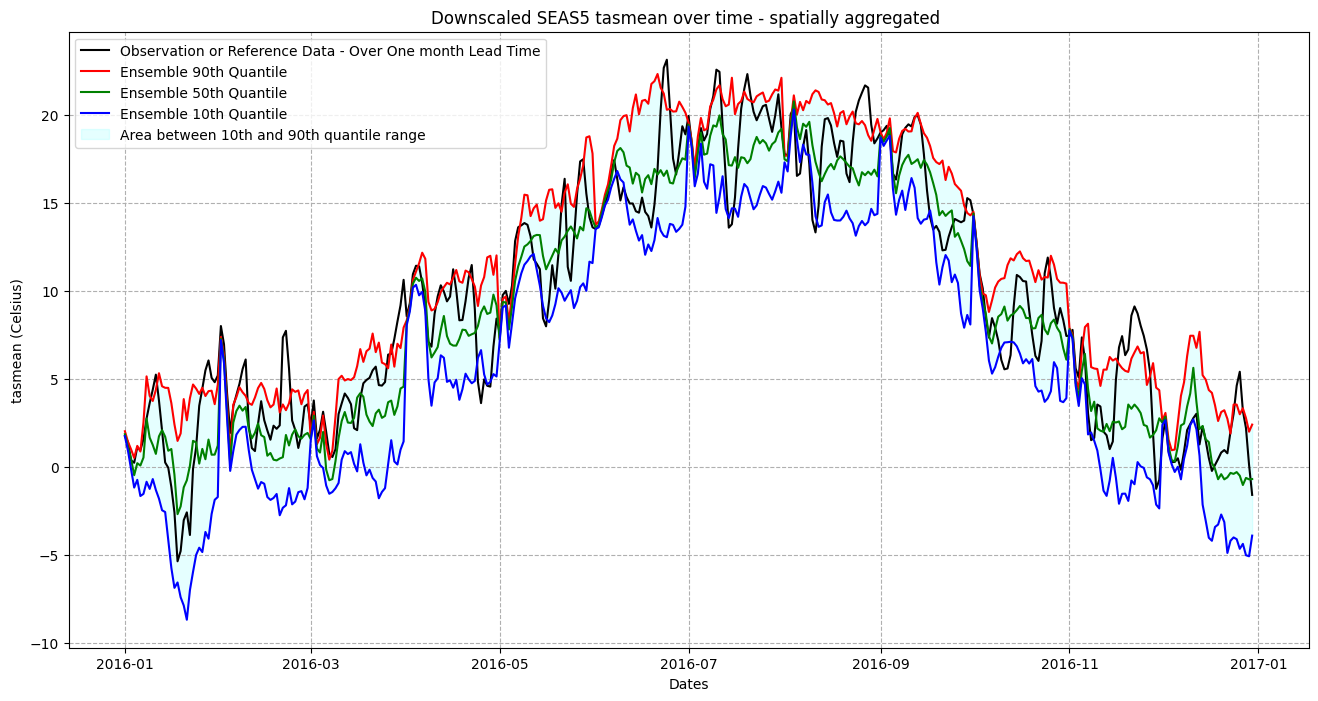

In [8]:

#SEAS5 Forecast Data Spatial Aggregation
data = y_pred.mean(['y', 'x'])
data = data[list(data.data_vars)[0]]
data
variable = list(y_pred.data_vars)[0]

#CERRA Reanalysis Data Spatial Aggregation
ref = y_true.mean(['y', 'x'])
ref = ref[list(ref.data_vars)[0]]

#Picking the Quantile for the Ensemble Members
data_90 = data.quantile(0.9, dim='number')
data_10 = data.quantile(0.1, dim='number')
data_50 = data.quantile(0.5, dim='number')

fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue', 'cyan']
ax.plot(ref.time, ref[:], color=f'{colours[0]}', label=f'Observation or Reference Data - Over One month Lead Time')
ax.plot(data_90.time, data_90[:], color=f'{colours[1]}', label=f'Ensemble 90th Quantile')
ax.plot(data_50.time, data_50[:], color=f'{colours[2]}', label=f'Ensemble 50th Quantile')
ax.plot(data_10.time, data_10[:], color=f'{colours[3]}', label=f'Ensemble 10th Quantile')
ax.fill_between(ref.time, data_90[:], data_10[:], alpha=0.1, color=f'{colours[4]}', label=f'Area between 10th and 90th quantile range')

#ax.set_xlim(2020-01-01,2020-12-31)
ax.set_title(f'Downscaled SEAS5 {variable} over time - spatially aggregated ')
ax.set_ylabel(f'{variable} (Celsius)')
ax.set_xlabel('Dates')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'SEAS5_annual_{variable}.png')

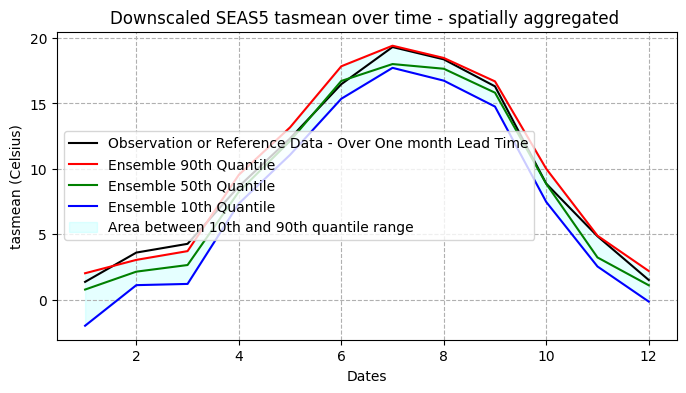

In [9]:
import numpy

weights = np.cos(np.deg2rad(y_pred.y))
weights.name = "weights"
ds_weighted = y_pred.weighted(weights)

data = ds_weighted.mean(dim=["y", "x"])
#SEAS5 Forecast Data Spatial Aggregation
#data = y_pred.mean(['y', 'x'])

data = data[list(data.data_vars)[0]]
data
variable = list(y_pred.data_vars)[0]
data = data.groupby('time.month').mean(keep_attrs=True)


#CERRA Reanalysis Data Spatial Aggregation
ref = y_true.mean(['y', 'x'])
ref = ref[list(ref.data_vars)[0]]
ref = ref.groupby('time.month').mean(keep_attrs=True)

ref


#Picking the Quantile for the Ensemble Members
data_90 = data.quantile(0.9, dim='number')
data_10 = data.quantile(0.1, dim='number')
data_50 = data.quantile(0.5, dim='number')

fig, ax = plt.subplots(1, 1, figsize = (8, 4))

colours = ['black','red','green','blue', 'cyan']
ax.plot(ref.month, ref[:], color=f'{colours[0]}', label=f'Observation or Reference Data - Over One month Lead Time')
ax.plot(data_90.month, data_90[:], color=f'{colours[1]}', label=f'Ensemble 90th Quantile')
ax.plot(data_50.month, data_50[:], color=f'{colours[2]}', label=f'Ensemble 50th Quantile')
ax.plot(data_10.month, data_10[:], color=f'{colours[3]}', label=f'Ensemble 10th Quantile')
ax.fill_between(ref.month, data_90[:], data_10[:], alpha=0.1, color=f'{colours[4]}', label=f'Area between 10th and 90th quantile range')

#ax.set_xlim(2020-01-01,2020-12-31)
ax.set_title(f'Downscaled SEAS5 {variable} over time - spatially aggregated ')
ax.set_ylabel(f'{variable} (Celsius)')
ax.set_xlabel('Dates')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'SEAS5_annual_{variable}.png')

In [10]:
import xarray as xr

dem = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/DEM/interTwin_dem.nc")

(array([6.216e+03, 4.983e+03, 1.636e+03, 8.940e+02, 6.790e+02, 4.910e+02,
        3.590e+02, 1.590e+02, 3.500e+01, 4.000e+00]),
 array([   0.        ,  381.77206421,  763.54412842, 1145.31616211,
        1527.08825684, 1908.86035156, 2290.63232422, 2672.40454102,
        3054.17651367, 3435.94873047, 3817.72070312]),
 <BarContainer object of 10 artists>)

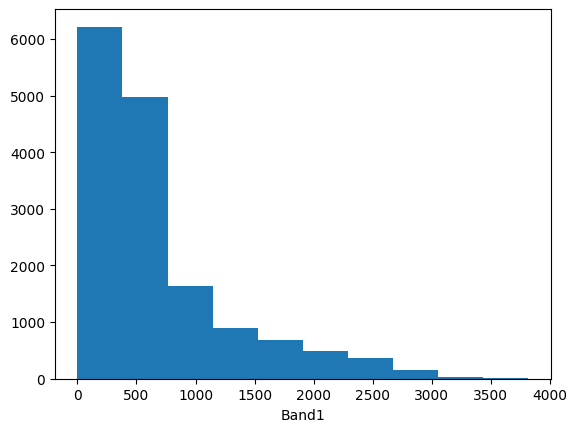

In [11]:
dem.Band1.plot.hist()

In [12]:
data_variable = dem['Band1'].values


In [13]:
import numpy as np
hist, bins = np.histogram(data_variable, bins=4)  # 'auto' selects the number of bins automatically


In [14]:
hist

array([12212,  2196,   938,   110])

In [15]:
bins

array([   0.    ,  954.4302, 1908.8604, 2863.2905, 3817.7207],
      dtype=float32)

In [16]:
data_90 = dem.quantile(0.9)
data_25 = dem.quantile(0.25)
data_50 = dem.quantile(0.5)
data_75 = dem.quantile(0.75)
data_10 = dem.quantile(0.10)

In [17]:
data_10

<xarray.Dataset> Size: 16B
Dimensions:   ()
Coordinates:
    quantile  float64 8B 0.1
Data variables:
    Band1     float64 8B 5.789

In [18]:
data_90

<xarray.Dataset> Size: 16B
Dimensions:   ()
Coordinates:
    quantile  float64 8B 0.9
Data variables:
    Band1     float64 8B 1.627e+03

In [19]:
dem1 = dem.Band1<241.1

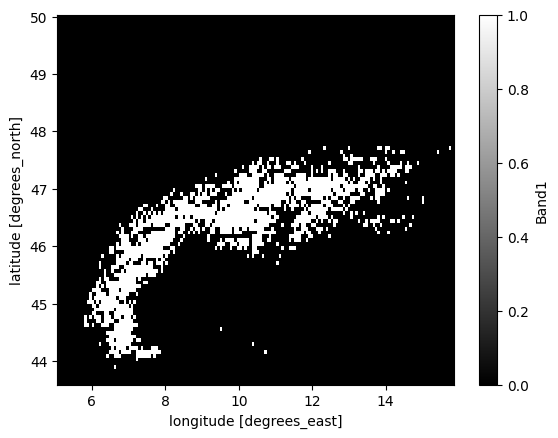

In [20]:
import matplotlib.pyplot as plt
dem1 = dem.Band1>1627

dem1.plot(cmap='gray')  # Using viridis colormap as an example

# Customize the colormap so that 0 values are white
cmap = plt.cm.viridis  # You can replace 'viridis' with any other colormap you prefer
cmap.set_bad(color='white', alpha=1.0)  # Set 0 values to white

# Show the plot
plt.show()

In [21]:
dem1

<xarray.DataArray 'Band1' (lat: 96, lon: 161)> Size: 15kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lon      (lon) float64 1kB 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * lat      (lat) float64 768B 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0

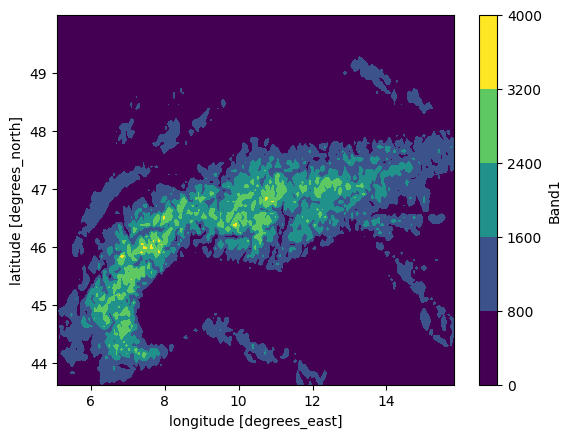

In [22]:
dem.Band1.plot.contourf()

In [23]:
dem

<xarray.Dataset> Size: 64kB
Dimensions:  (lon: 161, lat: 96)
Coordinates:
  * lon      (lon) float64 1kB 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * lat      (lat) float64 768B 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
Data variables:
    Band1    (lat, lon) float32 62kB 68.72 80.2 166.2 ... 241.7 236.7 252.5
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Dec 13 12:38:41 2023: cdo remapbil,/mnt/CEPH_PROJECTS/I...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [24]:
import xskillscore as xs



In [25]:
y_pred

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, number: 25, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-01-01 2016-01-02 ... 2016-12-30
  * number   (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x, number) float64 1GB 10.37 10.21 ... -4.195 -1.103

In [26]:
y_true

<xarray.Dataset> Size: 23MB
Dimensions:            (x: 161, y: 96, time: 365)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 3kB 2016-01-01 ... 2016-12-30
Data variables:
    tasmean            (time, y, x) float32 23MB 10.06 9.826 ... -3.397 -3.36
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [27]:
ds = xs.crps_ensemble(y_true, y_pred, dim = ['time'], member_dim = 'number')

/tmp/ipykernel_69756/2964363251.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(projection=ccrs.PlateCarree())


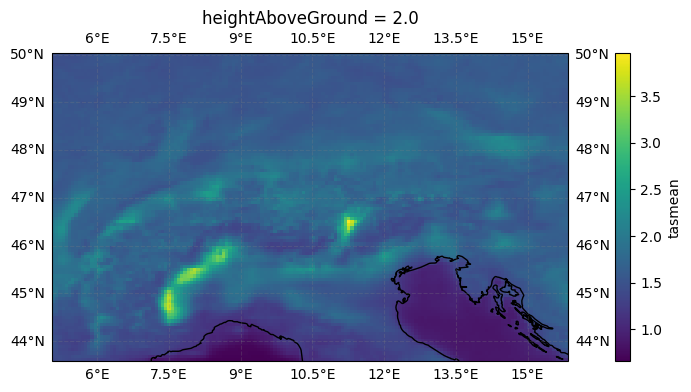

In [44]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(1, 1, figsize = (12, 4))

ax = plt.subplot(projection=ccrs.PlateCarree())
ds.tasmean.plot.pcolormesh(x="x", y="y", ax=ax)
ax.coastlines()
# Create custom linestyle and color for gridlines
linestyle = '--'  # Double dashes for dotted lines
color = 'gray'     # Adjust transparency with alpha value (0: fully transparent, 1: opaque)
alpha = 0.25        # Set desired transparency level (between 0 and 1)

# Set gridlines properties
ax.gridlines(draw_labels=True, linestyle=linestyle, color=color, alpha=alpha)
plt.show()

In [29]:
ds1 = xs.crps_ensemble(y_true, y_pred, dim = ['x', 'y'], member_dim = 'number')

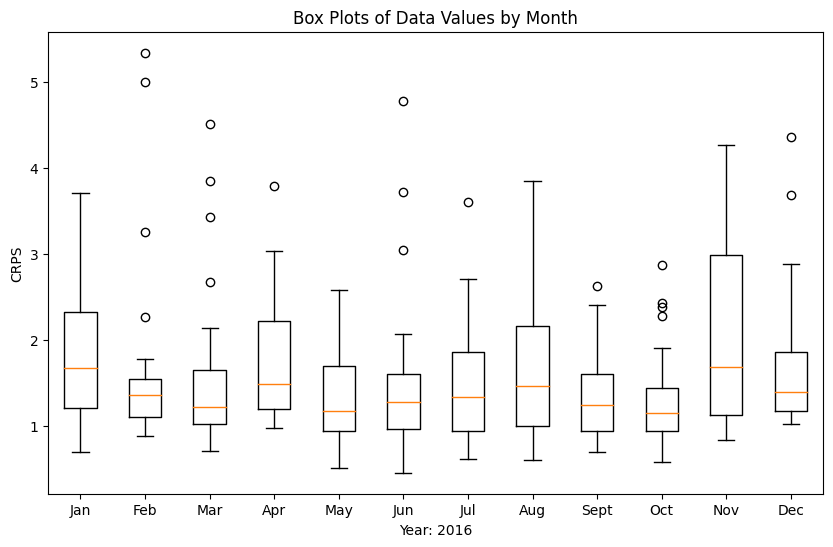

In [41]:
import matplotlib.pyplot as plt
import xarray as xr

# Get the month labels
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

grouped = ds1.tasmean.groupby('time.month')

monthly_values = []
for month, group in grouped:
    monthly_values.append(group.values)
# Create a box plot for each month
plt.figure(figsize=(10, 6))
plt.boxplot(monthly_values, labels=month_labels)
plt.xlabel('Month')
plt.ylabel('CRPS')
plt.xlabel(f"Year: {year}")
plt.title('Box Plots of Data Values by Month')
plt.grid(False)
plt.show()